# Mango Leaf Disease Classification using CNN, grad-CAM, and Deep feature extraction + KNN/SVM

<h1><b> Summary Report </b></h1>

This project aims to differentiate among various diseases (multiclass prediction) present in mango leaves. Various machine learning techniques were employed in this project to achieve optimal performance in a model capable of predicting multiple classes.

<h2><b> About the dataset </b></h2>

<h3><b>Description</b></h3>

<ul>
    <li>Type of data: 240x320 mango leaf images.</li>
    <li>Data format: JPG.</li>
    <li>Number of images: 4000 images. Of these, around 1800 are of distinct leaves, and the rest are prepared by zooming and rotating where deemed necessary.</li>
    <li>Diseases considered (classes): Seven diseases, namely Anthracnose, Bacterial Canker, Cutting Weevil, Die Back, Gall Midge, Powdery Mildew, Healthy and Sooty Mould.</li>
    <li>Distribution of instances: Each of the eight categories contains 500 images.</li>
    <li>How data are acquired: Captured from mango trees through the mobile phone camera.</li>
    <li>Data source locations: Four mango orchards of Bangladesh, namely Sher-e-Bangla Agricultural University orchard, Jahangir Nagar University orchard, Udaypur village mango orchard, and Itakhola village mango orchard.</li>
</ul>

For more details, refer to:

Ali, Sawkat; Ibrahim, Muhammad ; Ahmed, Sarder Iftekhar ; Nadim, Md. ; Mizanur, Mizanur Rahman; Shejunti, Maria Mehjabin ; Jabid, Taskeed (2022), “MangoLeafBD Dataset”, Mendeley Data, V1, doi: 10.17632/hxsnvwty3r.1

<h2><b> Solution and results </b></h2>

The dataset consists of 4000 images distributed among 8 classes, with a total of 1800 images representing various leaf disease classes. The remaining images are augmented data derived from these classes. Initially, a CNN model was built as a starting point to examine whether the convolutional layers could effectively extract information from the leaf areas.

Also, a Gradient-weighted Class Activation Mapping (grad-CAM) was employed to understand and visualize the crucial regions of an input image that influenced the classification made by the CNN.

The CNN model exhibited strong performance in both training and validation phases. However, it performed poorly with the test data, indicating a need for additional data to generalize and achieve satisfactory interclass differentiation. Consequently, an alternative approach was employed, utilizing a pretrained model (VGG16) for deep feature extraction. This was combined with a baseline model (KNN) and a comparison model (Support Vector Machine).

<h3><b> Results </b></h3>

Finally, the baseline model achieved an accuracy of 82%, whereas the comparison model outperformed with an accuracy of 98%. The confusion matrices of both models are shown in the following figures.

<div style="display: flex; justify-content: space-between;">
    <div>        
        <img src="https://raw.githubusercontent.com/EnriqManComp/Mango-Leaf-Disease-Classification/master/KNN.png" alt="KNN Model">
    </div>
    <div>        
        <img src="https://raw.githubusercontent.com/EnriqManComp/Mango-Leaf-Disease-Classification/master/SVM.png" alt="SVM Model">
    </div>
</div>

# Libraries

In [1]:
# Data manipulation and helpful libraries
import numpy as np 
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import itertools
import cv2
import seaborn as sns
from PIL import Image

# Machine Learning libraries
import tensorflow as tf 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Loading dataset

In [2]:
# Data main directory
dataset_dir = "/kaggle/input/mango-leaf-disease-dataset"
data = []
labels = []

for fold in os.listdir(dataset_dir):
    # Save the subfold names as labels 
    filepaths = os.path.join(dataset_dir, fold)
    for file in os.listdir(filepaths):
        # Save the data path
        data.append(os.path.join(filepaths,file))
        labels.append(fold)

# Convert to a pandas dataframe 
data_ = pd.Series(data, name='paths')
labels_ = pd.Series(labels, name = 'labels')
dataset = pd.concat([data_, labels_], axis=1)

In [3]:
dataset.head()

,paths,labels
0,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
1,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
2,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
3,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew
4,/kaggle/input/mango-leaf-disease-dataset/Powde...,Powdery Mildew


## Splitting the data

In [4]:
training_data, temp_validation_data = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=42, stratify=dataset['labels'])
validation_data, test_data = train_test_split(temp_validation_data, test_size=0.05, shuffle=True, random_state=42, stratify=temp_validation_data['labels'])
print(f"Dimension of the training data: {training_data.shape[0]}")
print(f"Dimension of the validation data: {validation_data.shape[0]}")
print(f"Dimension of the test data: {test_data.shape[0]}")

Dimension of the training data: 3200
Dimension of the validation data: 760
Dimension of the test data: 40


## Preparing the data

In [5]:
# Batch size
batch_size = 32
# Dataset image shape
img_shape = (224, 224)

# The original dataset was augmentated
# This function only returns the image as is
def return_image(image):
    return image

# Create a ImageDataGenerator
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)
validation_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image)

# Reading the images
training_data_gen = train_gen.flow_from_dataframe(training_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )
validation_data_gen = train_gen.flow_from_dataframe(validation_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )



Found 3200 validated image filenames belonging to 8 classes.
Found 760 validated image filenames belonging to 8 classes.


# Define the model

In [6]:
# The model
inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=2, data_format='channels_last')(inputs)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(4,4))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(2,2), strides=1)(x)
x = tf.keras.layers.LeakyReLU()(x)
x = tf.keras.layers.MaxPool2D(pool_size=(3,3))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=512)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(units=512)(x)
x = tf.keras.layers.ReLU()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(units=8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
# Optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

model_name = "model.h5"
# Define callback function
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
# Stopping parameters
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)
# Learning rate changes during training
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 111, 111, 32)      1568      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 111, 111, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 26, 26, 32)        0         
                                                             

# Training the model

In [7]:
history = model.fit(training_data_gen,
                    validation_data=validation_data_gen,
                    epochs=50,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 1.5744 - accuracy: 0.4863
Epoch 1: val_loss improved from inf to 2.47543, saving model to model.h5
100/100 [==============================] - 30s 279ms/step - loss: 1.5744 - accuracy: 0.4863 - val_loss: 2.4754 - val_accuracy: 0.3368 - lr: 1.0000e-04


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.9710 - accuracy: 0.6609
Epoch 2: val_loss improved from 2.47543 to 1.66359, saving model to model.h5
100/100 [==============================] - 24s 237ms/step - loss: 0.9710 - accuracy: 0.6609 - val_loss: 1.6636 - val_accuracy: 0.4842 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.7313 - accuracy: 0.7538
Epoch 3: val_loss improved from 1.66359 to 0.90859, saving model to model.h5
100/100 [==============================] - 24s 240ms/step - loss: 0.7313 - accuracy: 0.7538 - val_loss: 0.9086 - val_accuracy: 0.6868 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5626 - accuracy: 0.8081
Epoch 4: val_loss did not improve from 0.90859
100/100 [==============================] - 24s 243ms/step - loss: 0.5626 - accuracy: 0.8081 - val_loss: 0.9856 - val_accuracy: 0.6816 - lr: 1.0000e-04
Epoch 5/50
100/100 [==============================] - ETA:

# Plot training results

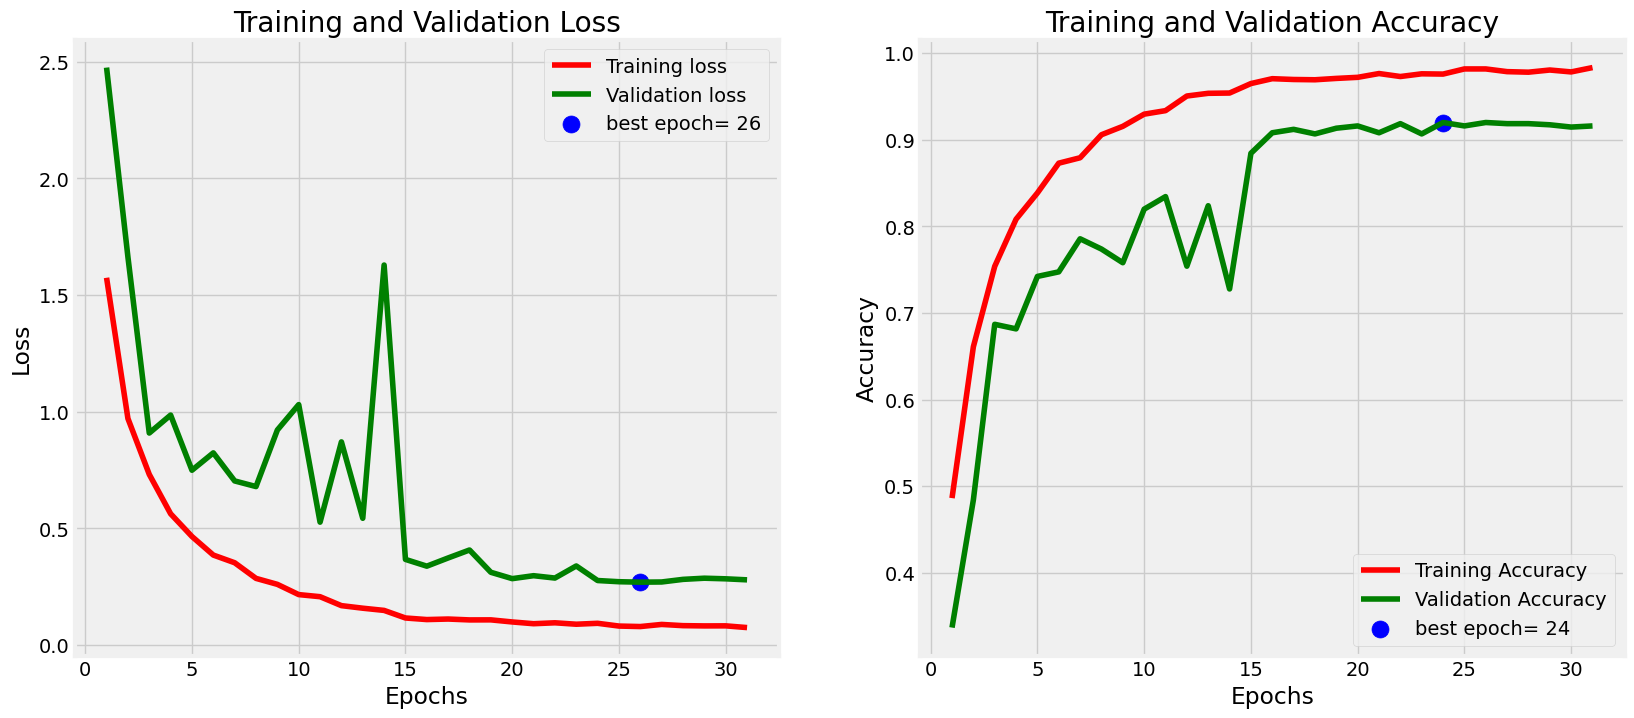

In [8]:
training_acc = history.history['accuracy']
training_loss = history.history['loss']
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']

# Select the min loss and the max accuracy achieved in the validation
index_loss = np.argmin(validation_loss)
val_lowest = validation_loss[index_loss]
index_acc = np.argmax(validation_acc)
acc_highest = validation_acc[index_acc]

# Arrange for plotting
epochs = [i+1 for i in range(len(training_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'r', label= 'Training loss')
plt.plot(epochs, validation_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_acc, 'r', label= 'Training Accuracy')
plt.plot(epochs, validation_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Testing the model

Found 40 validated image filenames belonging to 8 classes.
2/2 [==============================] - 0s 20ms/step


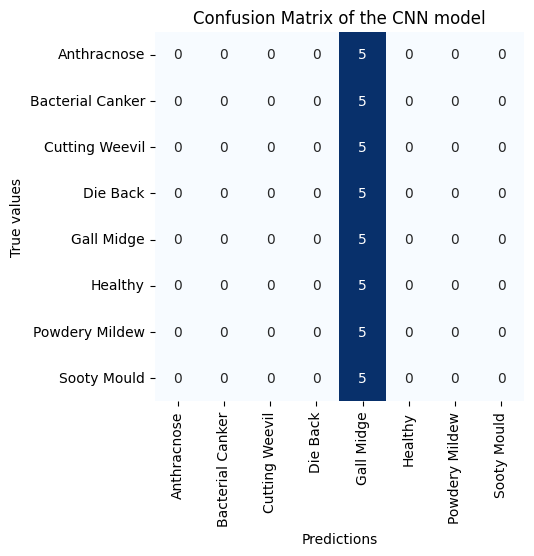

                  precision    recall  f1-score   support

     Anthracnose       0.00      0.00      0.00         5
Bacterial Canker       0.00      0.00      0.00         5
  Cutting Weevil       0.00      0.00      0.00         5
        Die Back       0.00      0.00      0.00         5
      Gall Midge       0.12      1.00      0.22         5
         Healthy       0.00      0.00      0.00         5
  Powdery Mildew       0.00      0.00      0.00         5
     Sooty Mould       0.00      0.00      0.00         5

        accuracy                           0.12        40
       macro avg       0.02      0.12      0.03        40
    weighted avg       0.02      0.12      0.03        40



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [9]:
plt.style.use('default')
# Define ImageDataGenerator and normalize
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=return_image, rescale=1./255)

# Reading the images
test_data_gen = test_gen.flow_from_dataframe(test_data,
                                              x_col = "paths",
                                              y_col="labels",
                                              shuffle=True,
                                              class_mode='categorical',
                                              target_size=img_shape,
                                              batch_size=batch_size,
                                              color_mode='rgb'                                             
                                             )
# Predict
preds = model.predict(test_data_gen)
# Select the max argument for each predictions
y_pred = np.argmax(preds, axis=1)

# Get classes names and mapping
g_dict = test_data_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_data_gen.classes, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=classes,
            yticklabels=classes)

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of the CNN model')
plt.show()

# Classification report
print(classification_report(test_data_gen.classes, y_pred, target_names= classes))

# Grad-CAM

In [10]:
def get_img_array(img_path, img_shape):
    # Load image
    img = tf.keras.utils.load_img(img_path, target_size=img_shape) 
    # Convert to array
    array = tf.keras.utils.img_to_array(img) / 255.0    
    # Add a dimension to the array image
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )    

    # Compute the gradient of the top predicted class for the input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)    

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, normalizing the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img) 
    
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matplotlib.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)
    
    return superimposed_img

## Display a sample of the test images

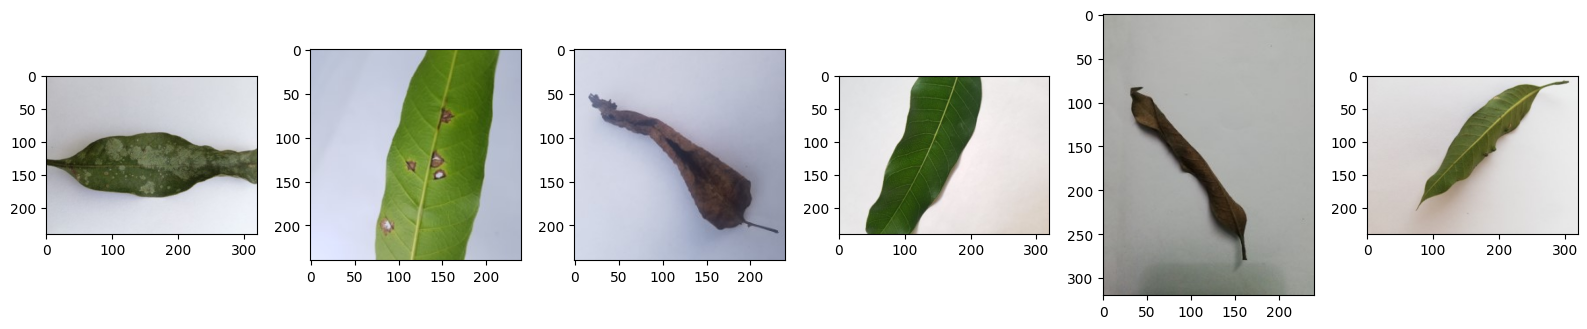

In [11]:
fig, axs = plt.subplots(1,6, figsize=(16,12))
axs[0].imshow(Image.open(test_data.iloc[0,0]))
axs[1].imshow(Image.open(test_data.iloc[1,0]))
axs[2].imshow(Image.open(test_data.iloc[2,0]))
axs[3].imshow(Image.open(test_data.iloc[3,0]))
axs[4].imshow(Image.open(test_data.iloc[4,0]))
axs[5].imshow(Image.open(test_data.iloc[5,0]))
plt.tight_layout()
plt.show()

### Perform grad-CAM

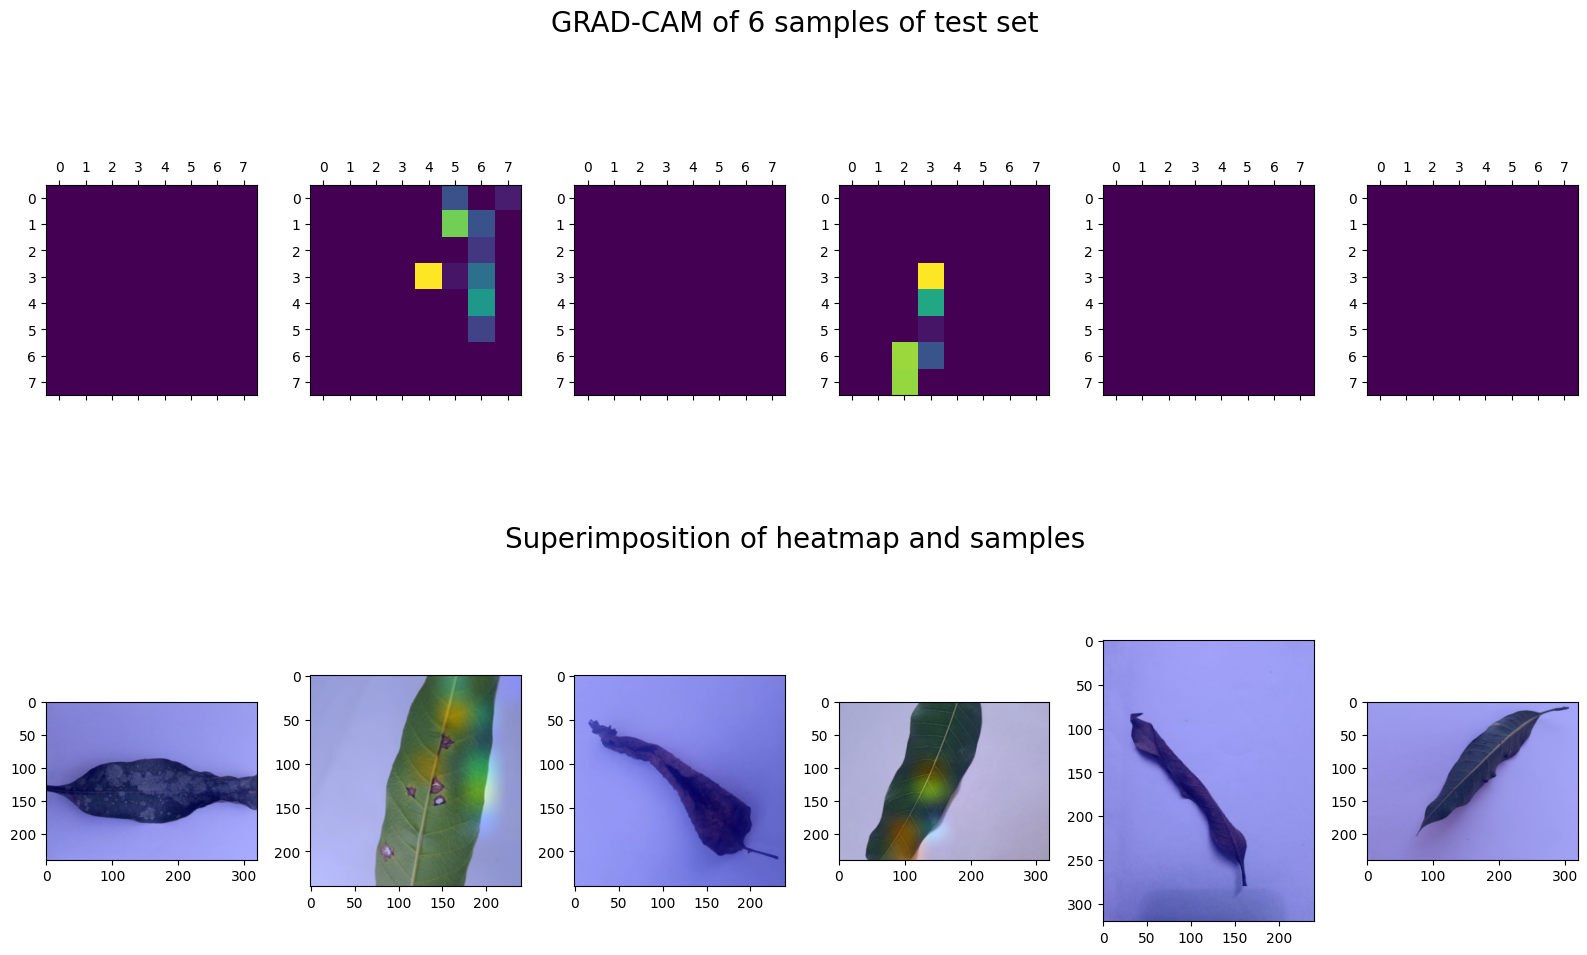

In [12]:
last_conv_layer_name = "max_pooling2d_1"
fig, ax = plt.subplots(2,6, figsize=(16,12))

for i in range(6):
    img_array = get_img_array(test_data.iloc[i,0], img_shape=img_shape)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    ax[0,i].matshow(heatmap)
    # Superpose image and heatmap
    ax[1,i].imshow(display_gradcam(test_data.iloc[i,0], heatmap))


plt.tight_layout()
fig.text(0.5, 0.92, "GRAD-CAM of 6 samples of test set", ha='center', fontsize=20)
fig.text(0.5, 0.49, "Superimposition of heatmap and samples", ha='center', fontsize=20)
plt.show()

### 

The CNN model demonstrated good performance in both training and validation, but performed poorly with the test data, this indicates that the model requires more data to generalize and achieve satisfactory results in interclass differentiation. Despite this challenge, let's explore other techniques, such as utilizing a pretrained model for deep feature extraction.

Why did I choose these options? Pretrained models often exhibit good performance in interclass differentiation under certain conditions. However, even with this promising performance, we still lack sufficient data to fine-tune the weights in the trainable part of the model (specifically, the dense layers in the output of the pretrained model). While there are alternative techniques available, the idea of extracting deep features appears promising. Let's get to work.

# Deep feature extraction using VGG16

## Rearrange the data

In [13]:
# Loading dataset
def load_dataset(folder, img_size=(224, 224)):
    images = []
    labels = []
    for label in os.listdir(folder):
        file_path = os.path.join(folder, label)
        if os.path.isdir(file_path):
            for file in os.listdir(file_path):
                img_path = os.path.join(file_path, file)
                # Read image
                image = cv2.imread(img_path)
                # Convert from BGR color space to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Resize image
                image = cv2.resize(image, img_size)
                images.append(image)
                labels.append(label)
    # Converting to numpy array
    return np.array(images), np.array(labels)
dataset_path="/kaggle/input/mango-leaf-disease-dataset"

X, y = load_dataset(dataset_path)

## Split the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Define the model

In [15]:
# Load base pretrained VGG16 model
base_model = tf.keras.applications.VGG16(
                                          include_top= False,
                                          weights= "imagenet",
                                          input_shape= (224,224,3)

)

58889256/58889256 [==============================] - 0s 0us/step


In [16]:
# Freezing weights of base model
base_model.trainable = False
# Creating Sequential Model
deep_feat_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256,
                          kernel_regularizer = tf.keras.regularizers.l2(l = 0.016),
                          activity_regularizer = tf.keras.regularizers.l1(0.006),
                         bias_regularizer = tf.keras.regularizers.l1(0.006),
                         activation= "linear"
                         )    
    ])

## Extracting features for each set of data

In [17]:
train_features = deep_feat_model.predict(X_train)
test_features = deep_feat_model.predict(X_test)

25/25 [==============================] - 223s 9s/step


In [18]:
train_features.shape

(3200, 7, 7, 256)

## Reshaping extracted features

In [19]:
training_flatten = train_features.reshape(train_features.shape[0], -1)
test_flatten = test_features.reshape(test_features.shape[0], -1)

# Baseline model classifier

# KNN model

In [20]:
knn_model = KNeighborsClassifier()
knn_model.fit(training_flatten, y_train)

KNeighborsClassifier()

### Predict data

In [21]:
y_pred = knn_model.predict(test_flatten)

### Result metrics

                  precision    recall  f1-score   support

     Anthracnose       0.95      0.32      0.48       112
Bacterial Canker       0.91      0.98      0.94       101
  Cutting Weevil       1.00      1.00      1.00        86
        Die Back       0.53      1.00      0.69        93
      Gall Midge       0.89      0.83      0.86        90
         Healthy       0.71      0.98      0.82        91
  Powdery Mildew       0.87      0.86      0.87       123
     Sooty Mould       1.00      0.57      0.72       104

        accuracy                           0.80       800
       macro avg       0.86      0.82      0.80       800
    weighted avg       0.86      0.80      0.79       800



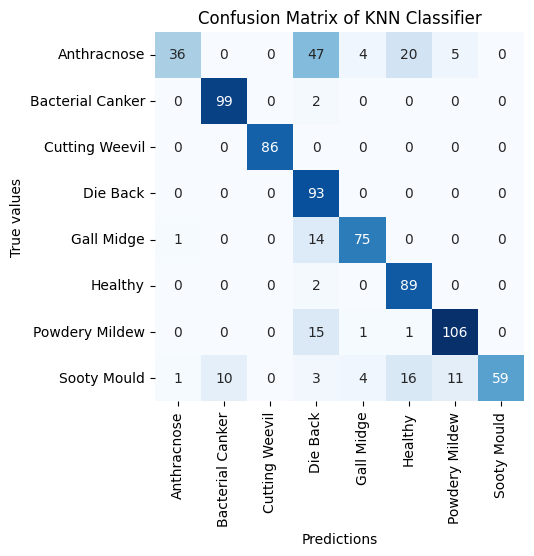

In [22]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix for each class
class_names = ["Anthracnose", "Bacterial Canker", "Cutting Weevil", "Die Back",
               "Gall Midge", "Healthy", "Powdery Mildew", "Sooty Mould"]

cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of KNN Classifier')
plt.show()

# Comparison models

### Support Vector Machine model

                  precision    recall  f1-score   support

     Anthracnose       0.99      0.98      0.99       112
Bacterial Canker       1.00      0.98      0.99       101
  Cutting Weevil       1.00      1.00      1.00        86
        Die Back       0.98      0.99      0.98        93
      Gall Midge       0.91      0.98      0.94        90
         Healthy       1.00      0.98      0.99        91
  Powdery Mildew       1.00      0.94      0.97       123
     Sooty Mould       0.95      0.99      0.97       104

        accuracy                           0.98       800
       macro avg       0.98      0.98      0.98       800
    weighted avg       0.98      0.98      0.98       800



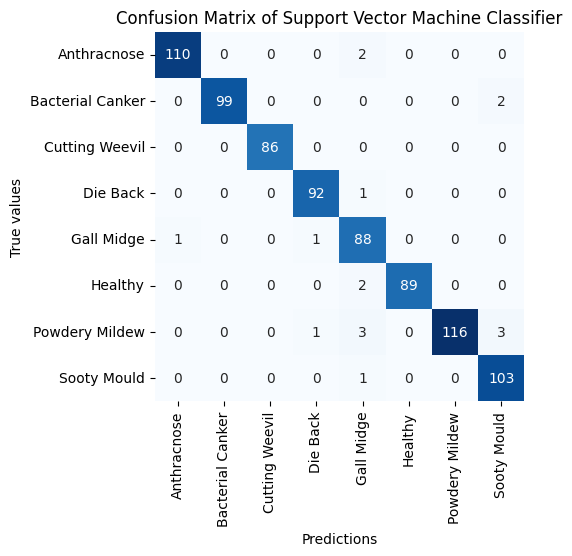

In [23]:
from sklearn.svm import SVC
svm_model = SVC()
# Fit model
svm_model.fit(training_flatten, y_train)
# Predict
y_pred_svm = svm_model.predict(test_flatten)
# Classification report
print(classification_report(y_test, y_pred_svm))
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, square=True,
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predictions')
plt.ylabel('True values')
plt.title('Confusion Matrix of Support Vector Machine Classifier')
plt.show()